In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch

import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior

import matplotlib as mpl
plt.rcParams['figure.dpi'] = 600

import warnings
warnings.simplefilter('ignore', FutureWarning)


# Get Collective Posterior
## $P(\theta|X_{1},...X_{n}) = $${{P(\theta)}^{1-n}\Pi_{i}[P(\theta|X_{i})]} \over {\int{{P(\theta)}^{1-n}}\Pi_{i}[P(\theta|X_{i})]d\theta}$

In [27]:
# Prior doesn't have to be identical to network's prior (here it is)
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'old_posteriors/posterior_chuong.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
epsilon = -150 # choice is detailed later

collective_posteriors = {}

lines = ['wt','ltr','ars','all']
for line in lines:
    amortized_posterior = posterior_chuong
    Xs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0) # observations
    Xs = torch.tensor(np.array(Xs), dtype=torch.float32)
    log_C = 1
    op = CollectivePosterior(prior, amortized_posterior, Xs, n_eval, log_C, epsilon=-150)
    print(op.get_log_C())
    collective_posteriors[line] = op # to use throughout the notebook
    
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
label_dict = {'wt': 'Wildtype', 'ltr': 'LTRΔ', 'ars': 'ARSΔ', 'all': 'ALLΔ', 'lauer': 'Lauer'}

tensor(561.5150)
tensor(635.7506)
tensor(795.4691)
tensor(868.5082)


# Collective MAPs (Maximum A-Posteriori)

In [28]:
for line in lines:
    print(f'{line} MAP: {list(collective_posteriors[line].get_map().round(2))}')
    print(collective_posteriors[line].log_prob(collective_posteriors[line].get_map()))

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # allow one-dim tensor for theta


wt MAP: [-0.74, -4.34, -3.77]
tensor([19.7987])
ltr MAP: [-0.74, -4.84, -4.32]
tensor([18.5191])
ars MAP: [-0.84, -5.62, -5.39]
tensor([11.7024])
all MAP: [-0.9, -5.05, -5.22]
tensor([12.9588])


In [29]:
for line in lines:
    collective_posteriors[line].sample(100)

# Marginal Collective Posteriors

In [30]:
import matplotlib as mpl

# fonts
label_size = 7
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = 16

# add specifics to plotting function
def plotline(line):
        label_dict = {'wt': 'A', 'ltr': 'C', 'ars': 'B', 'all': 'D', 'lauer': 'Lauer'}
        op = collective_posteriors[line]
        g = op.plot_pairwise(color=rep_colors[line])  
        g.fig.suptitle(label_dict[line], x=0, fontsize=20)
        plt.show()

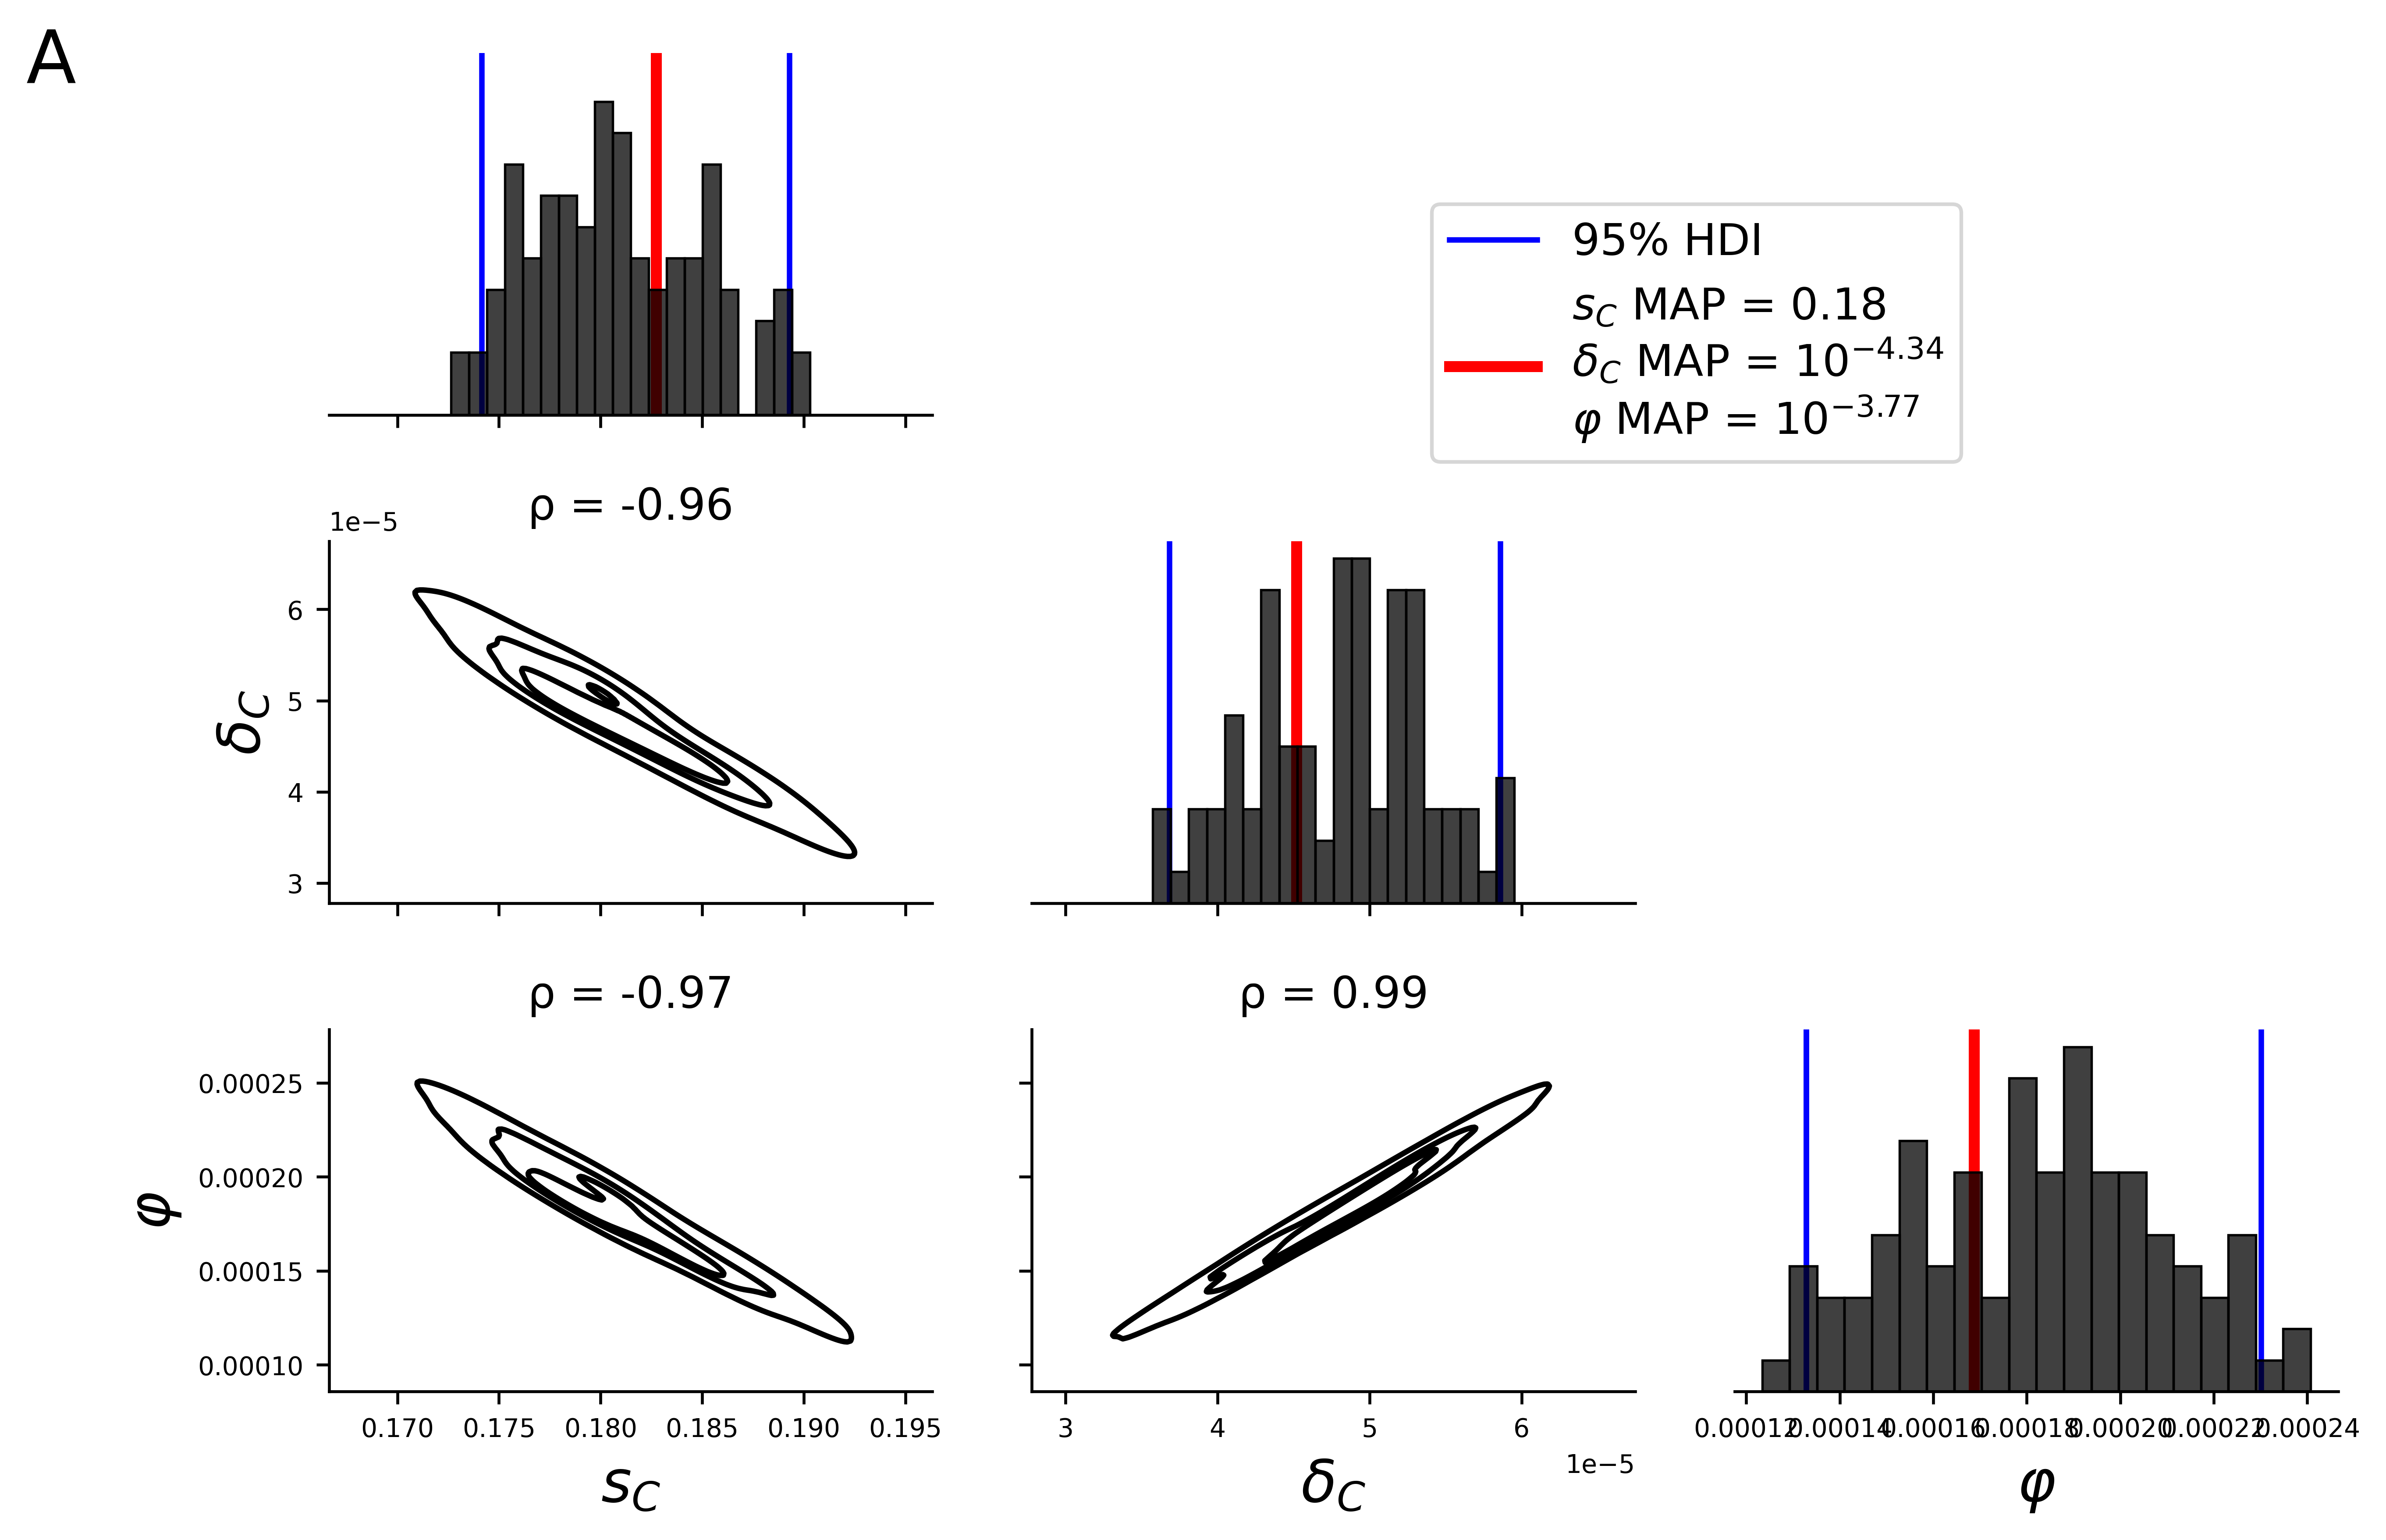

In [31]:
plotline('wt')

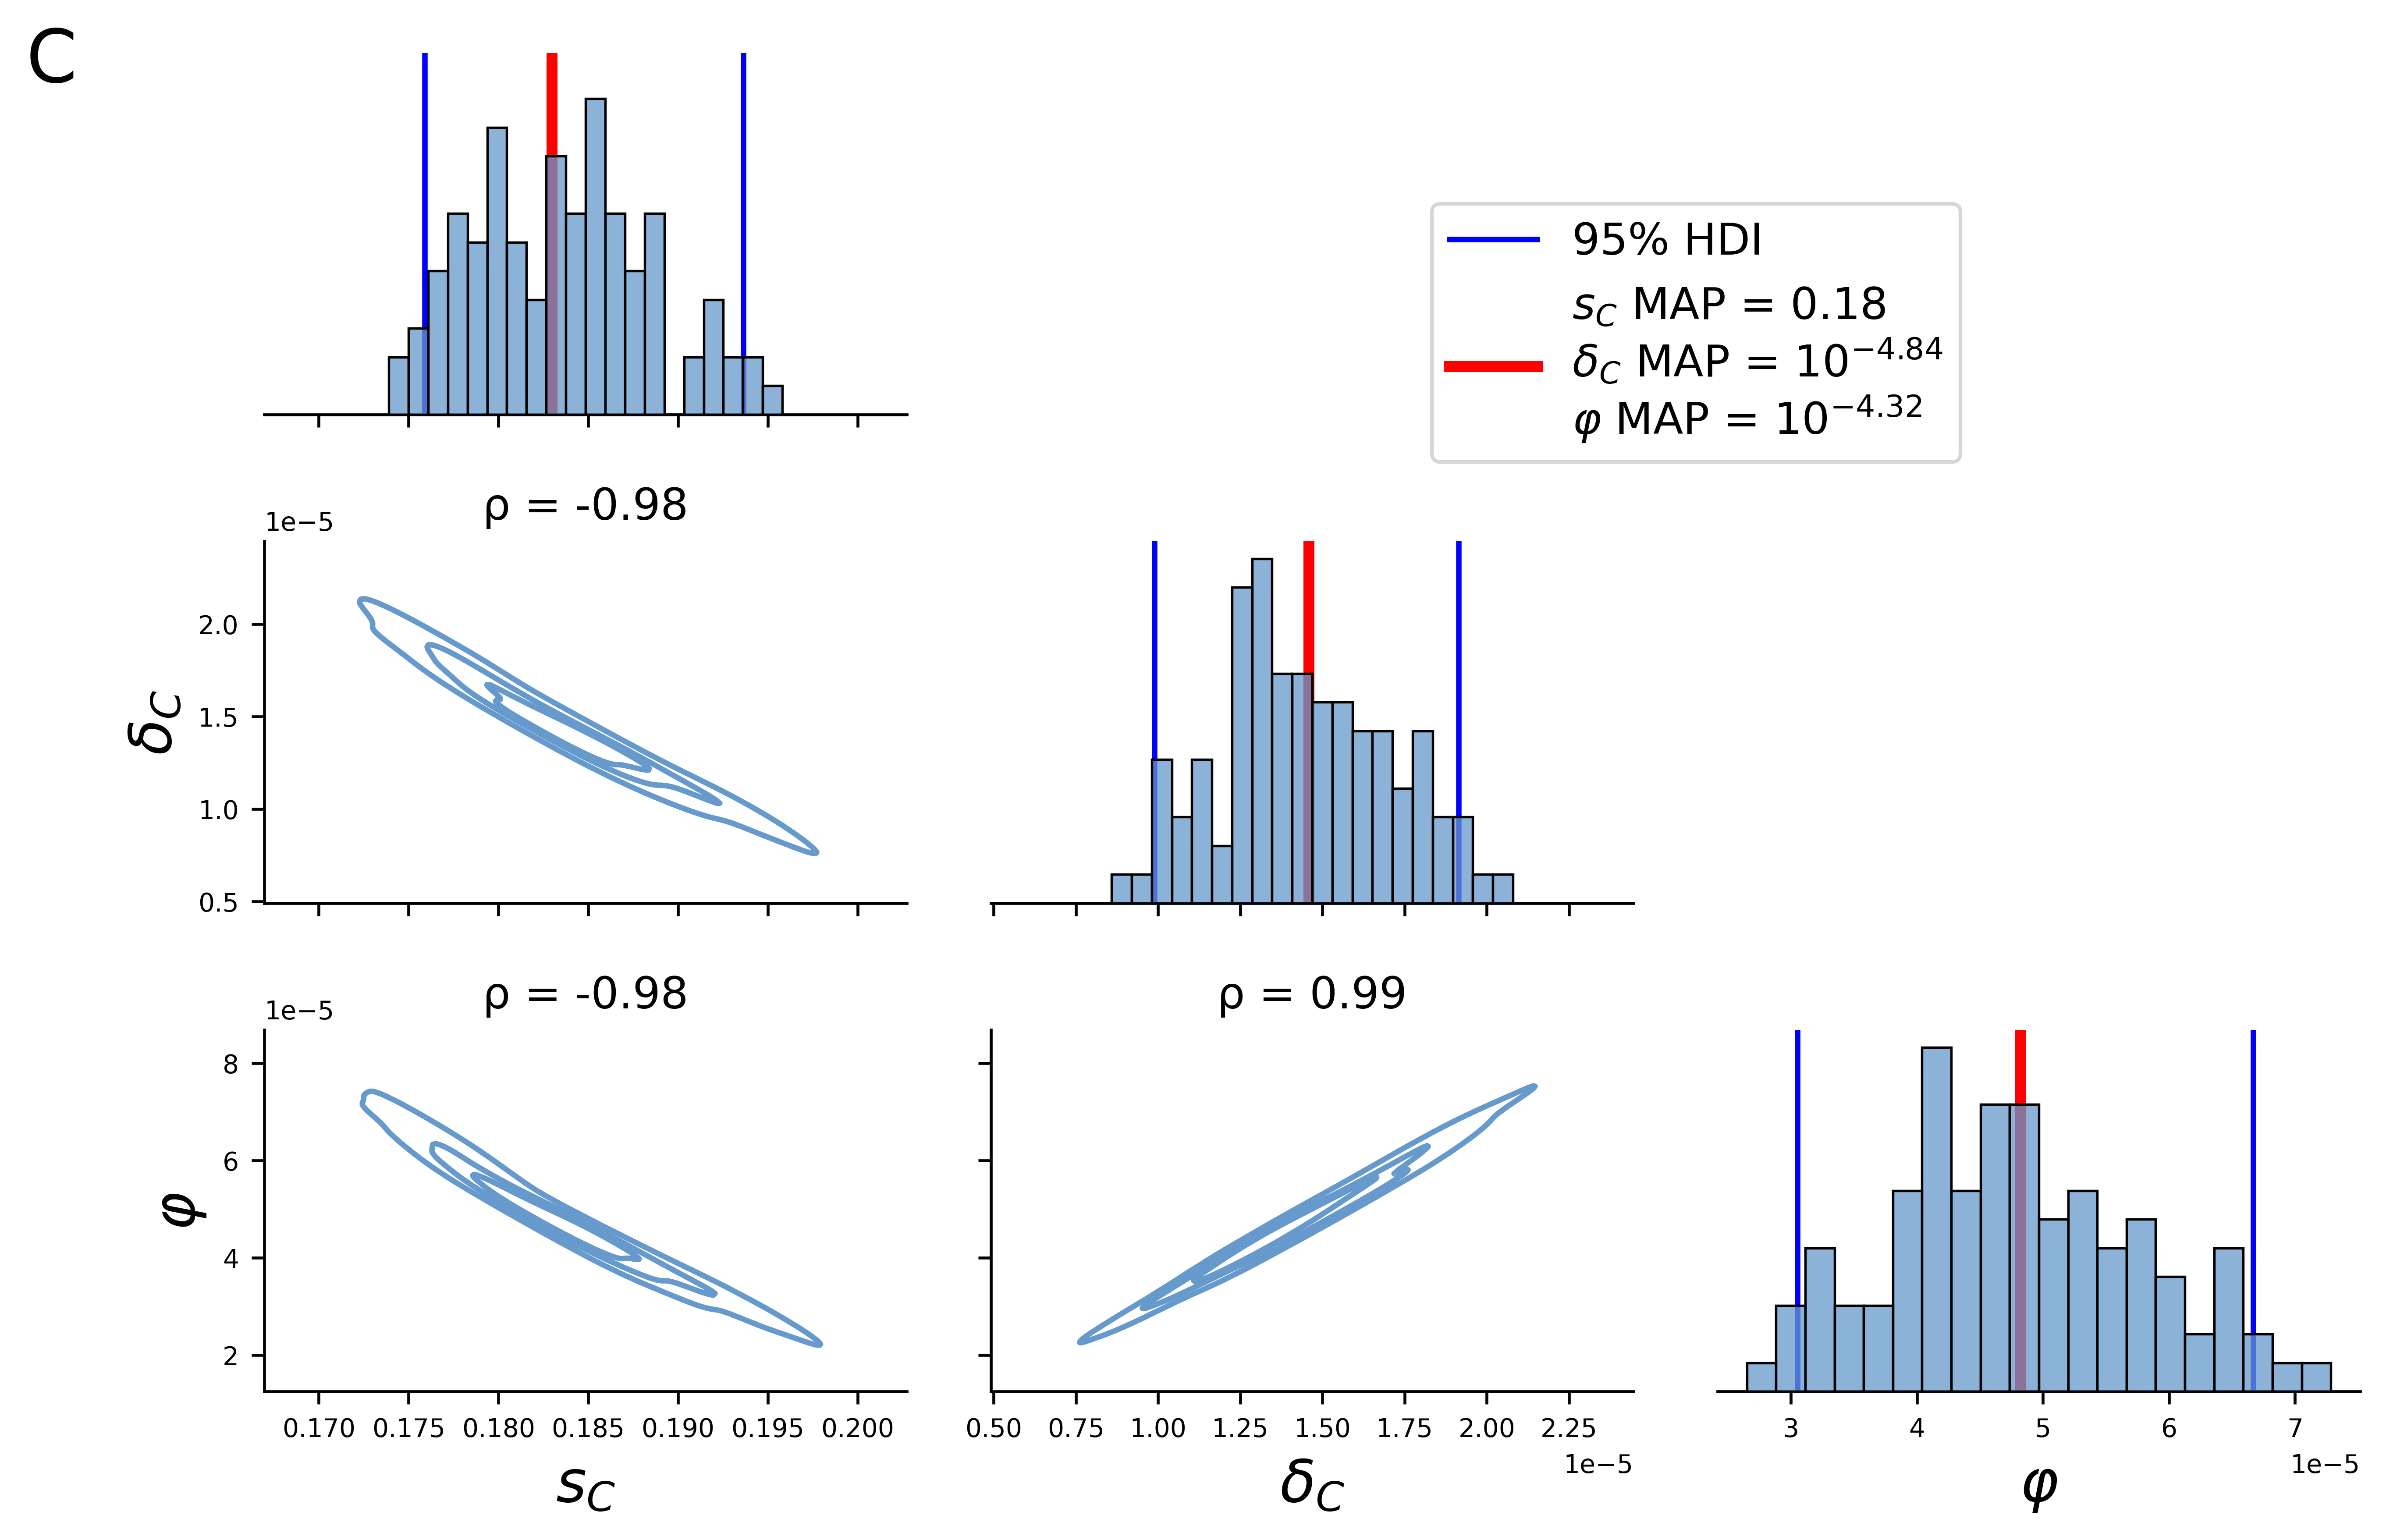

In [32]:
plotline('ltr')

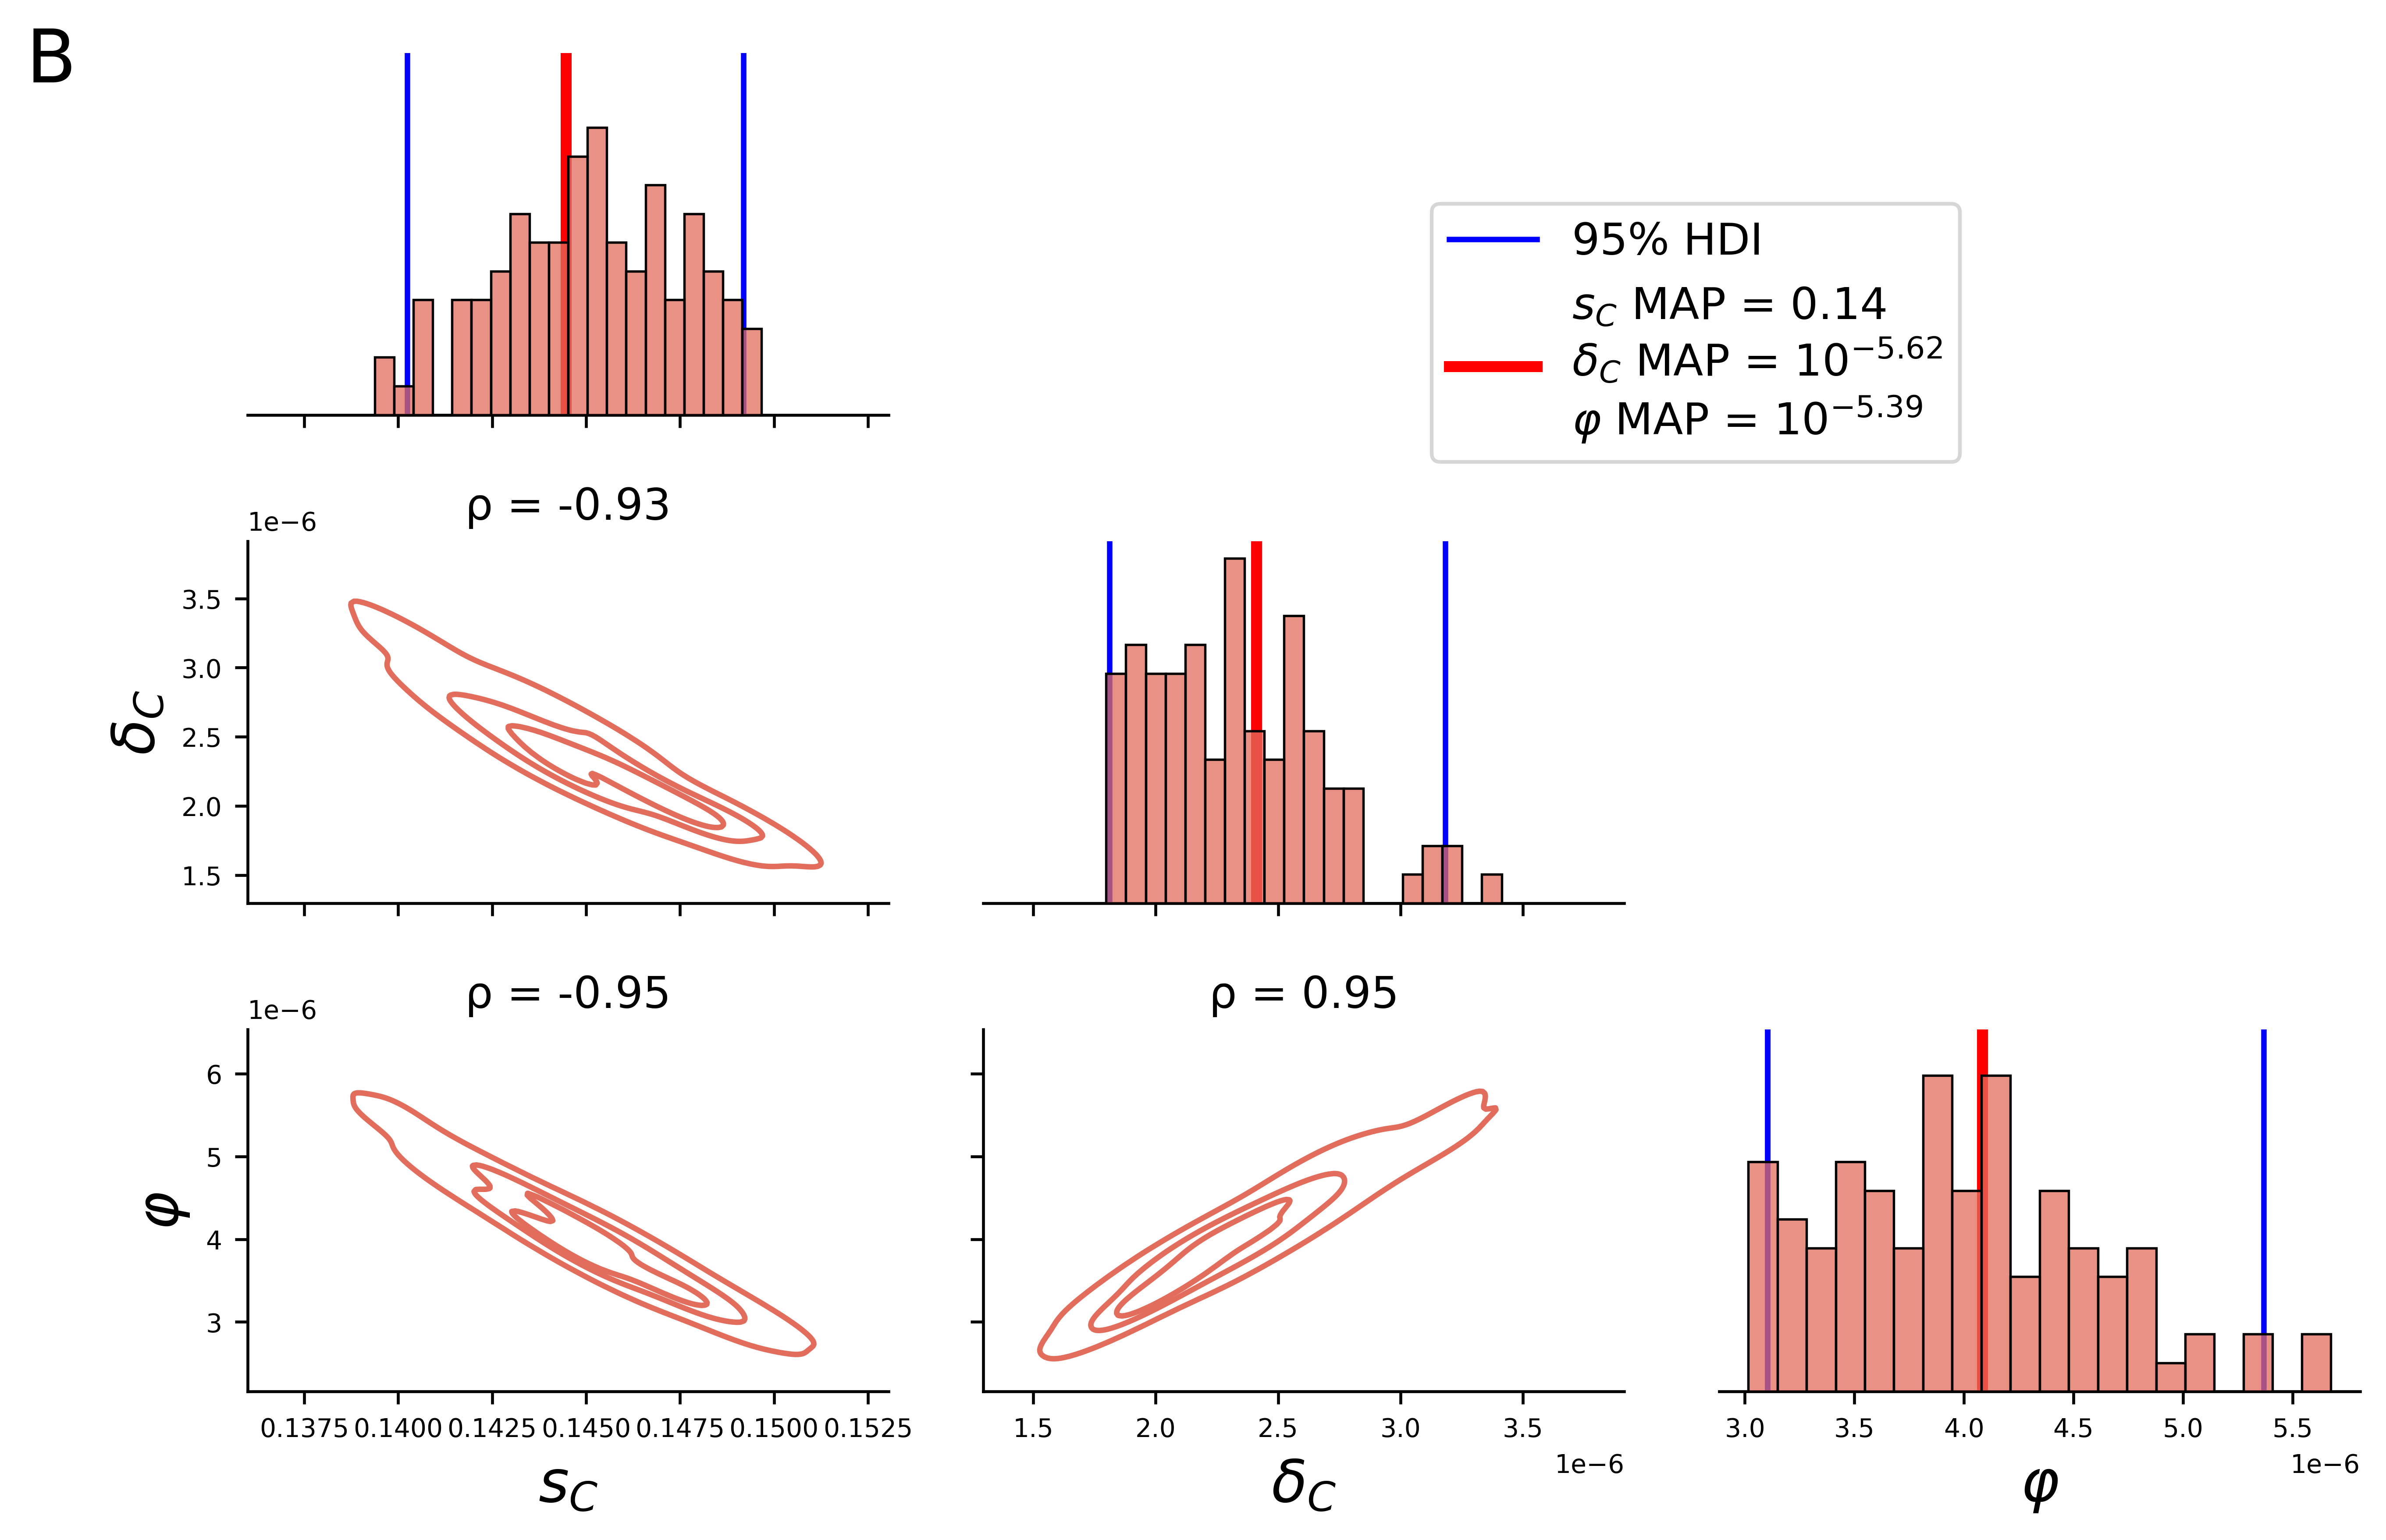

In [33]:
plotline('ars')

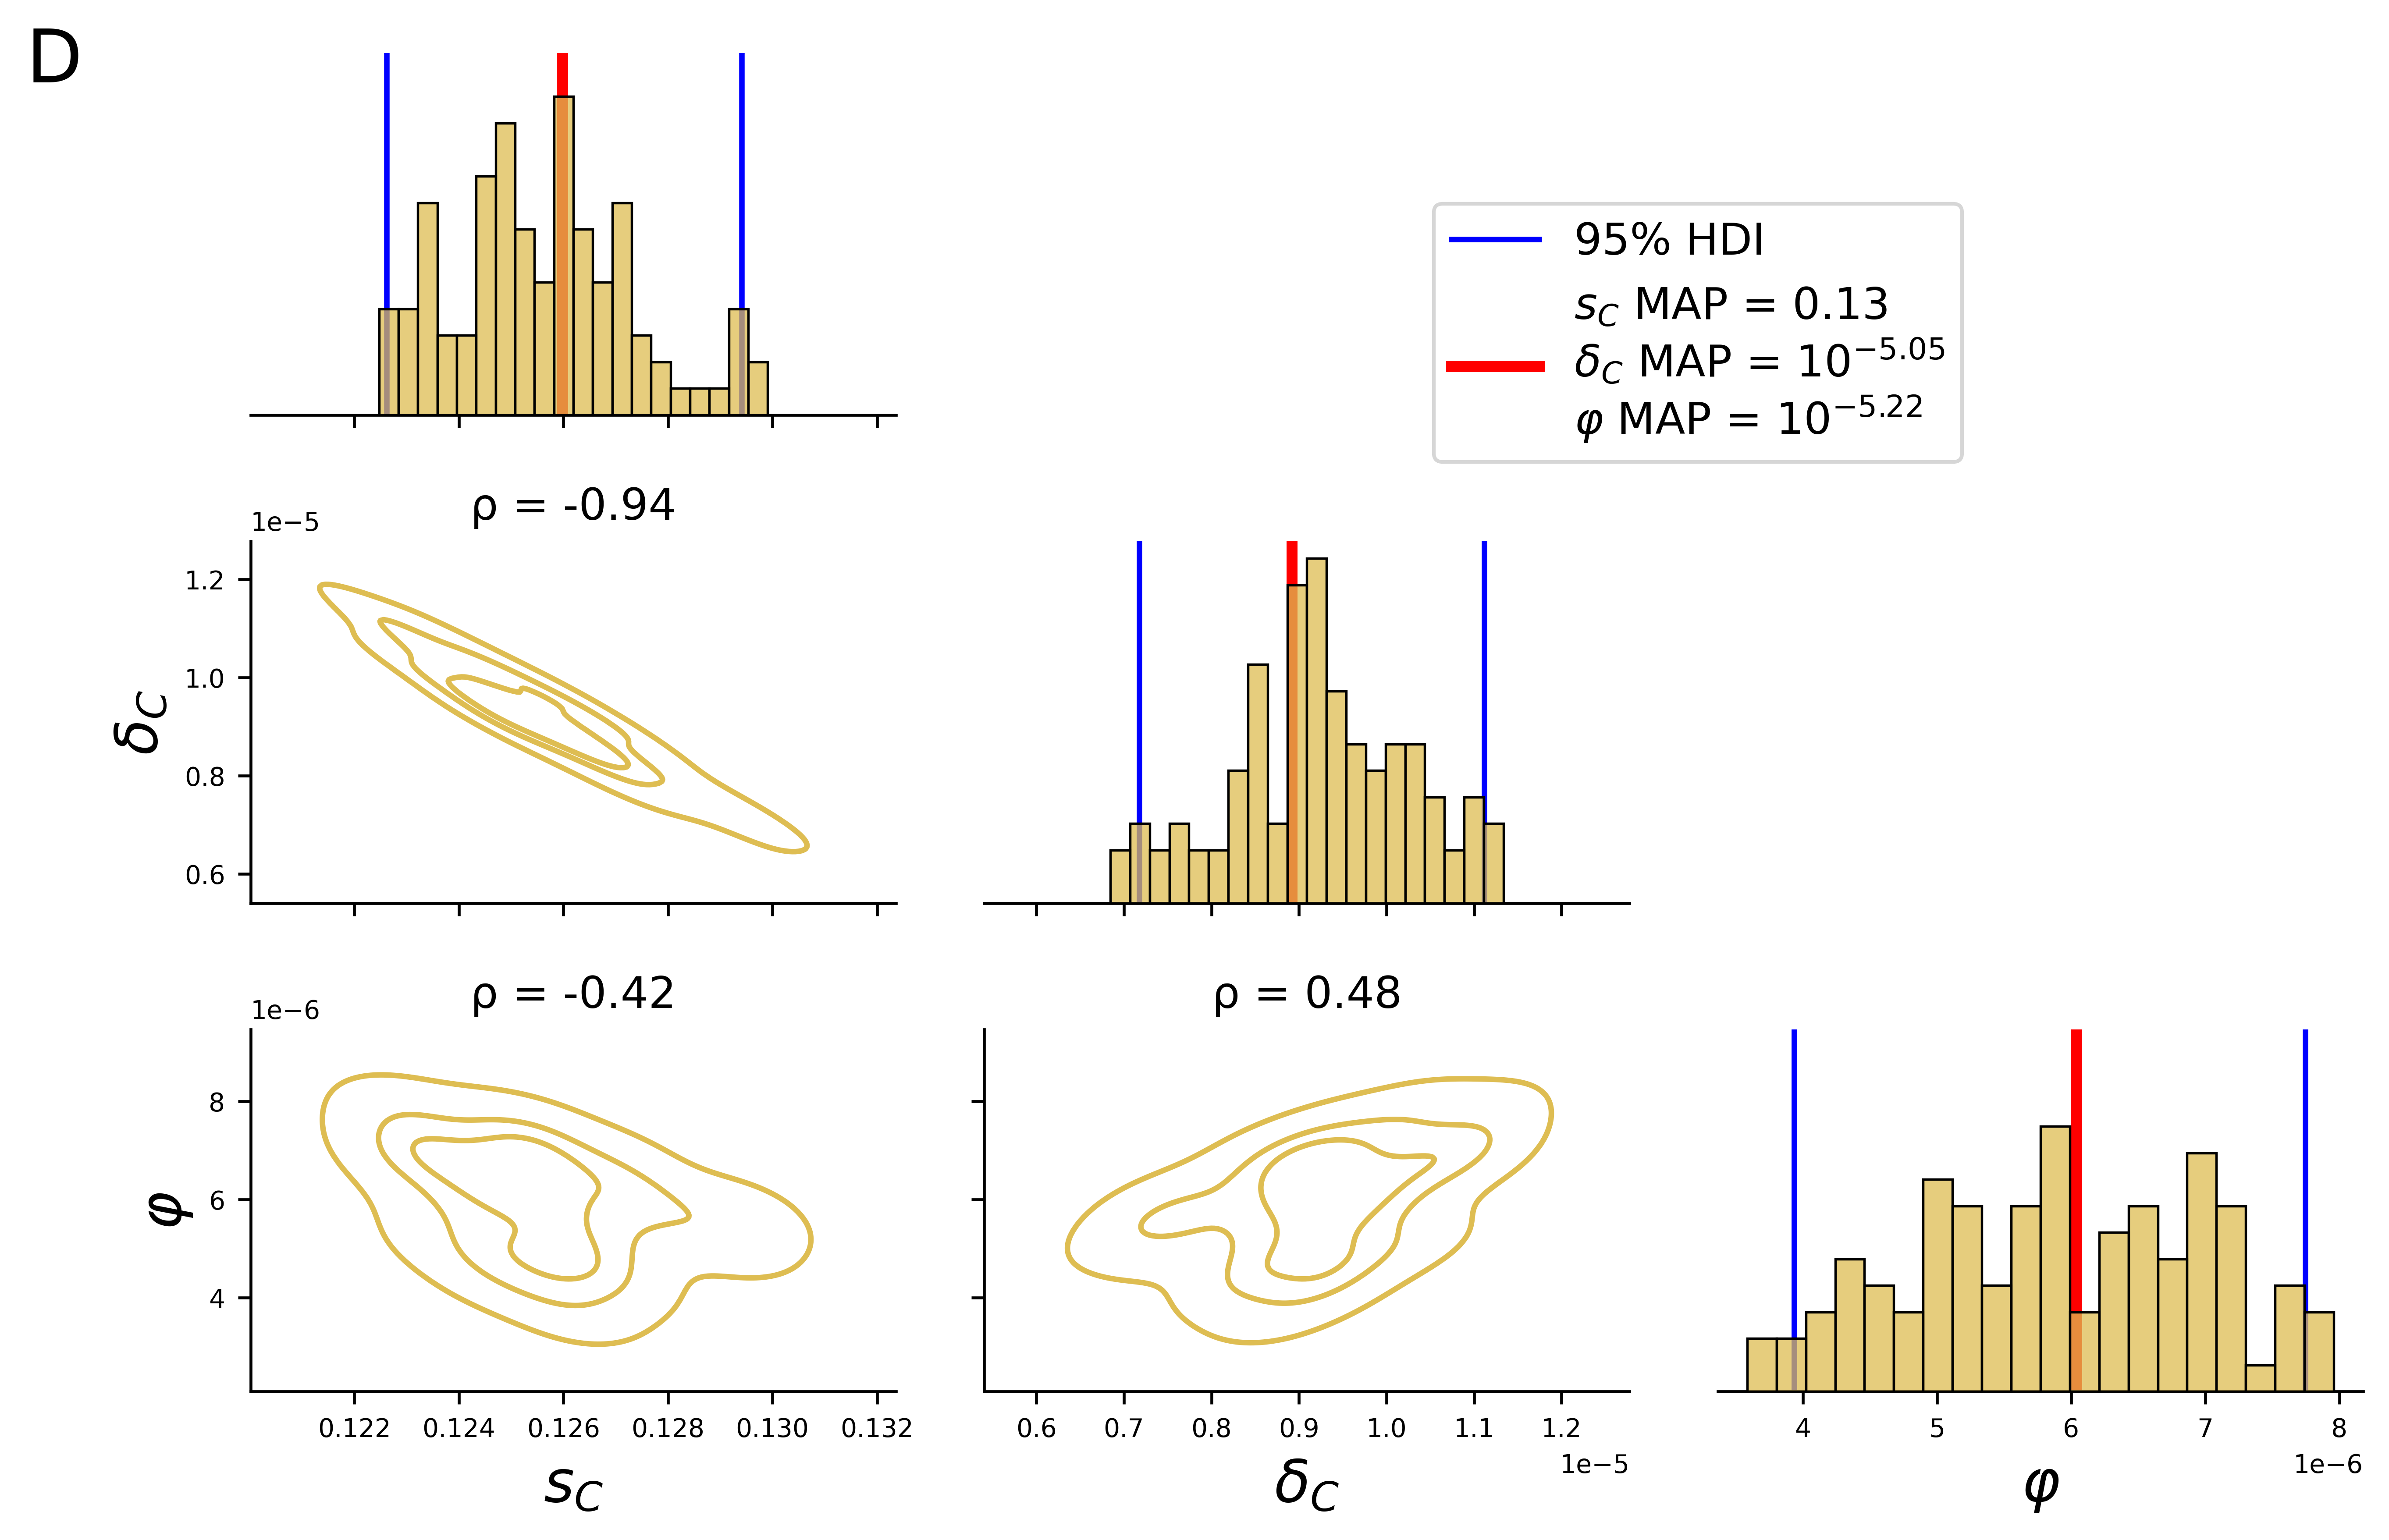

In [34]:
plotline('all')

# Collective Posterior Validation

## Predictive Checks - Simulate Collective Posterior MAP and compare to empirical observations

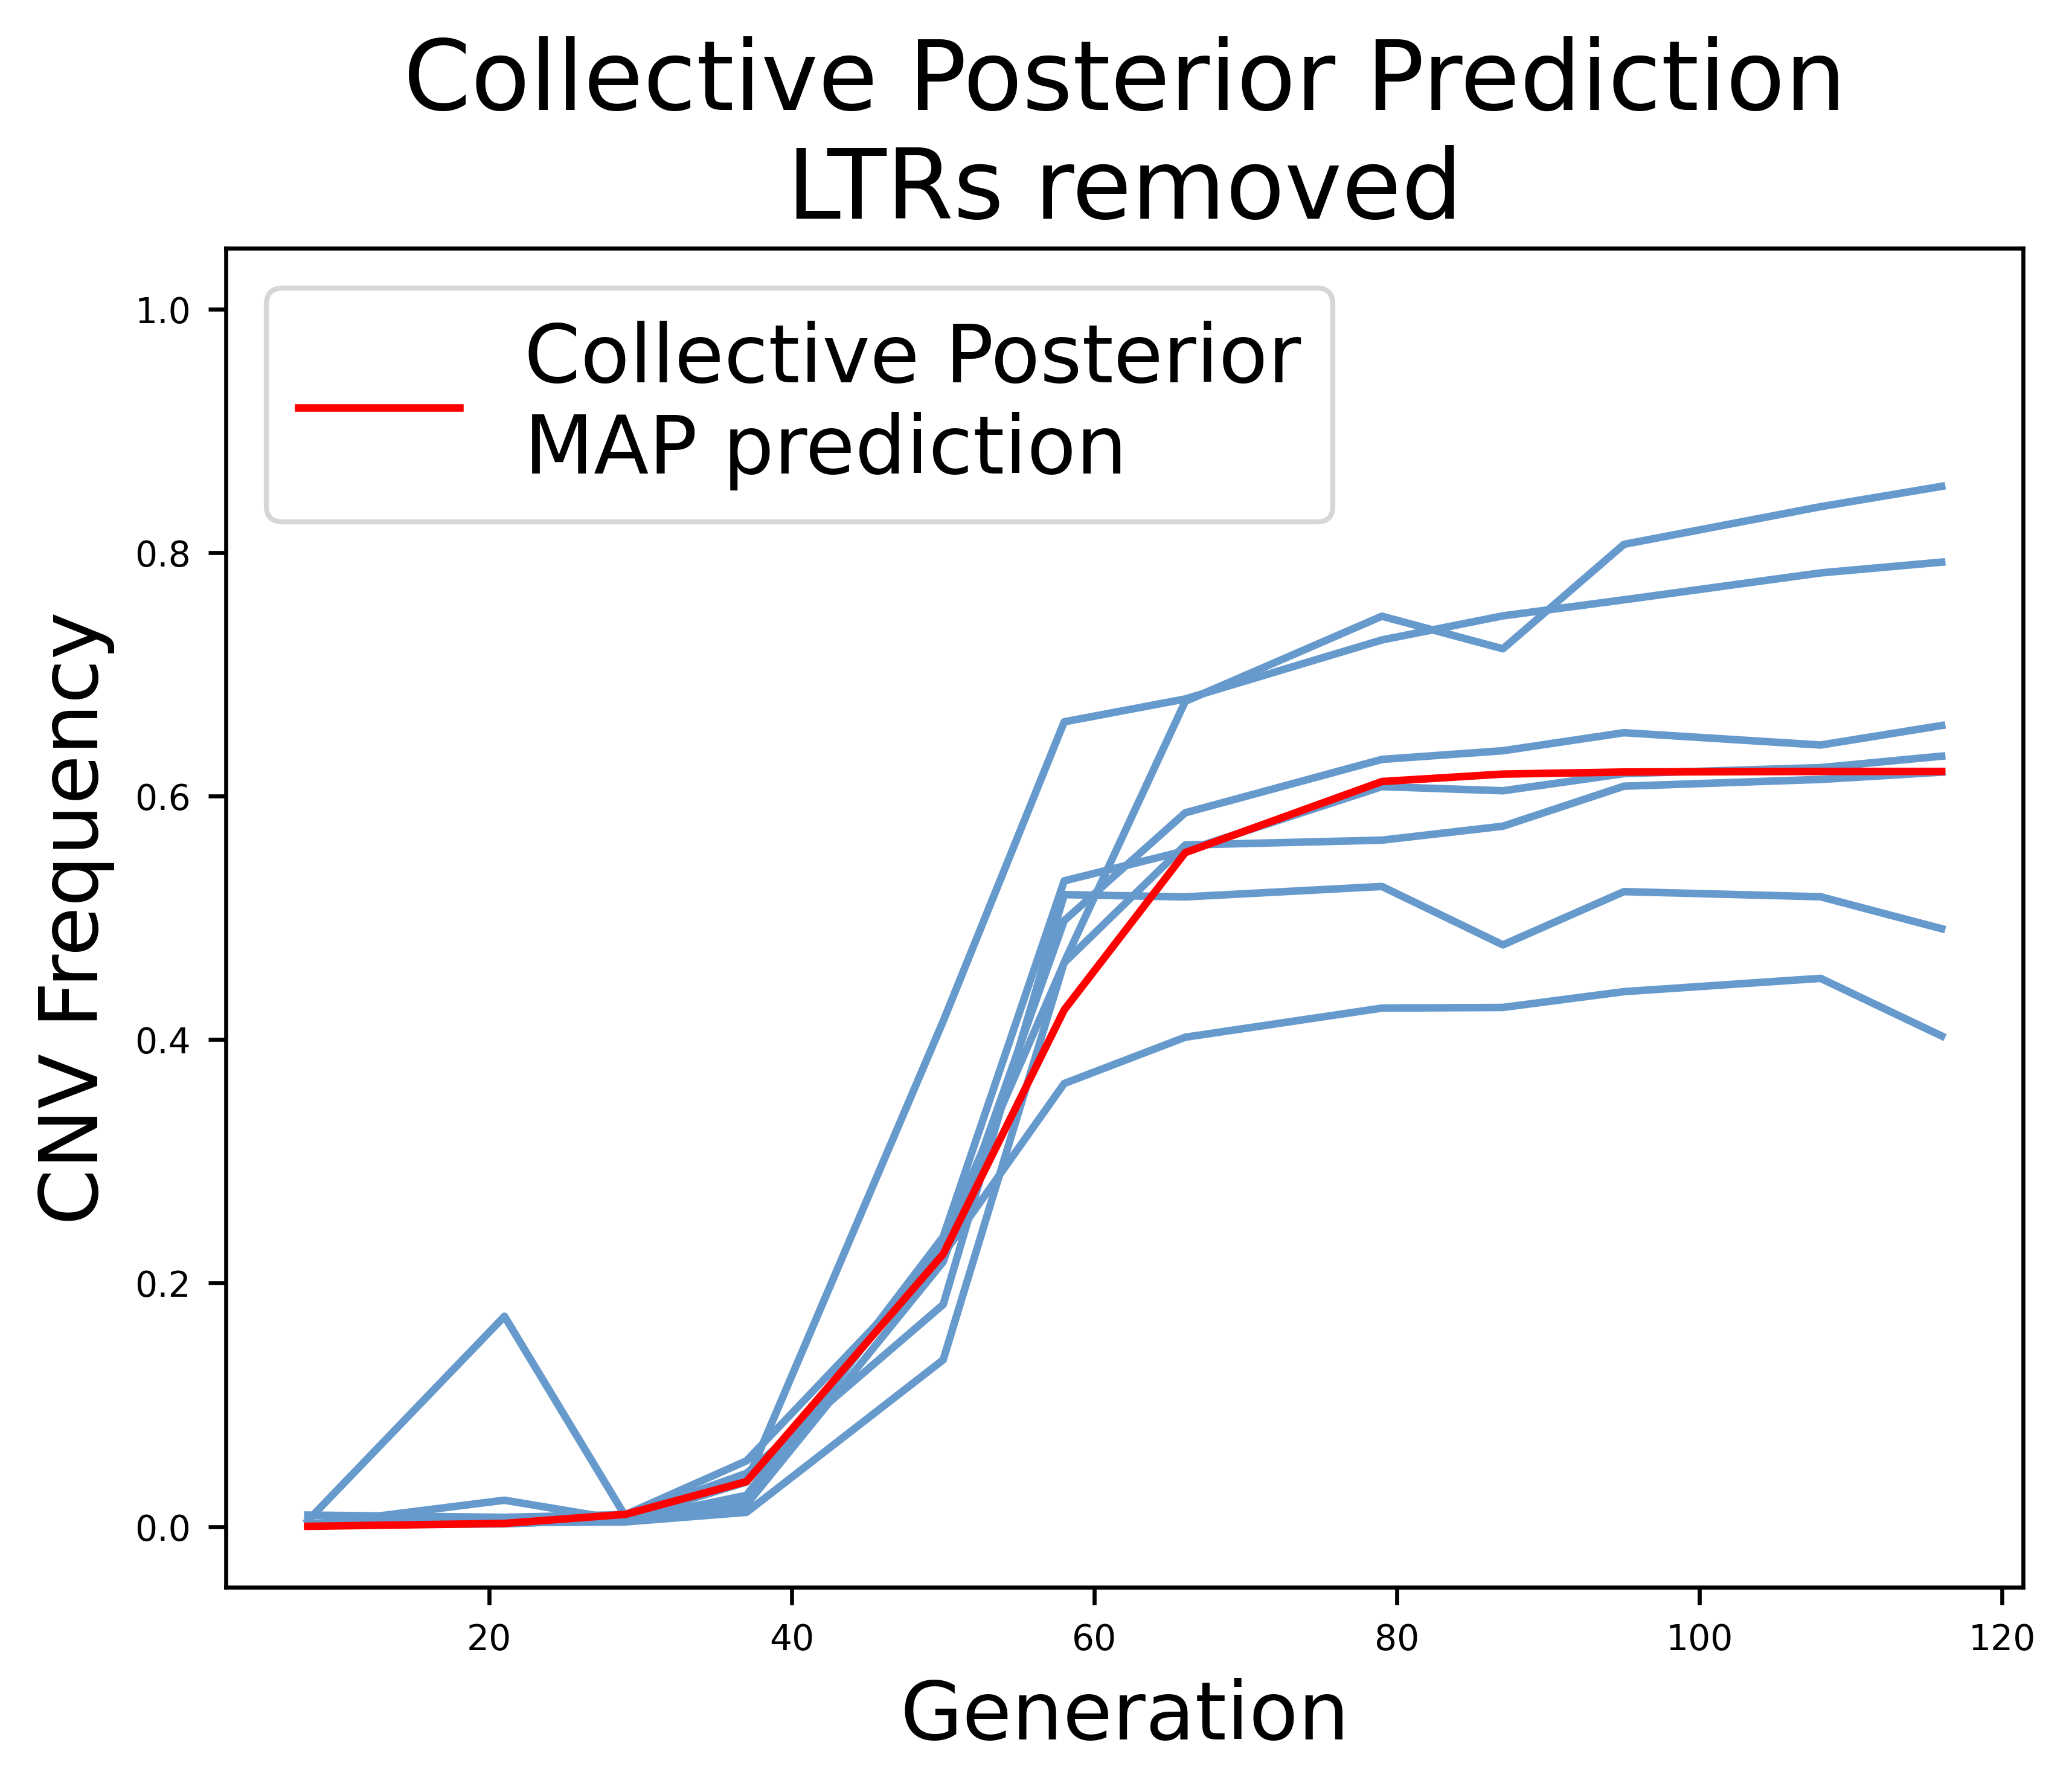

In [11]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Model (simulator)
reps = 1
generation = pd.read_csv('empirical_data/Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states

# Showing one example
line = 'ltr'
op = collective_posteriors[line]
for i in range(len(op.Xs)):
    plt.plot(generation.tolist(),op.Xs.iloc[i,:], color=rep_colors[line])

# Collective MAP
collective_map = op.map
params = torch.tensor(list(collective_map), dtype=torch.float64)
x = CNVsimulator(params).T
plt.plot(generation.tolist(),x, label = 'Collective Posterior\nMAP prediction', color='red')

# Plotting
plt.legend()
plt.title(f'Collective Posterior Prediction\n{label_dict[line]}')

plt.xlabel('Generation')
plt.ylabel('CNV Frequency')
plt.ylim(-0.05,1.05)
plt.show()

# Sensitivity to $\epsilon$

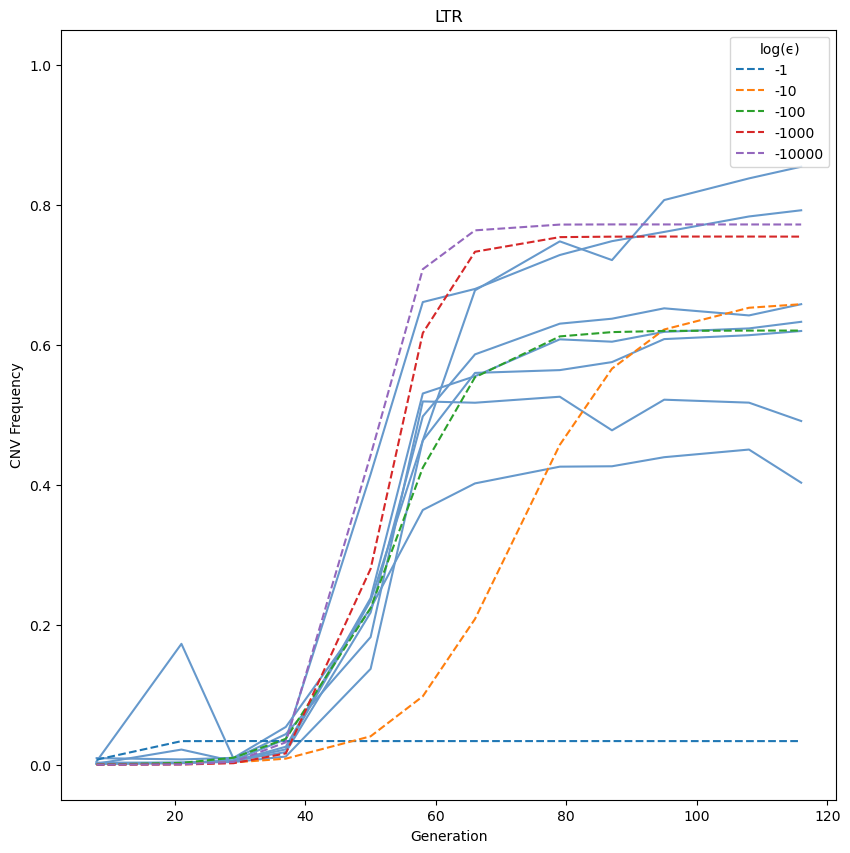

In [22]:
def plot_epsilons(ax, line, epsilons):
# Plot Collective Posterior prediction for WT
# Get data
    op = collective_posteriors[line]
    for i in range(len(op.Xs)):
        ax.plot(generation.tolist(),op.Xs.iloc[i,:], color=rep_colors[line])

    # Collective MAP
    for ϵ in epsilons:
        opp = CollectivePosterior(op.prior, op.amortized_posterior, Xs=op.Xs, n_eval=100, log_C=1, epsilon=ϵ)
        opp.get_log_C()
        collective_map = opp.get_map()
        params = torch.tensor(list(collective_map), dtype=torch.float64)
        x = CNVsimulator(params).T
        ax.plot(generation.tolist(),x, label = ϵ, linestyle='--')

    # Plotting
    ax.legend(title = 'log(ϵ)')
    ax.set_title(f'{line.upper()}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('CNV Frequency')
    ax.set_ylim(-0.05,1.05)

fig, ax = plt.subplots(figsize=(10,10))
epsilons=[-1,-10,-100,-1000, -10000]
plot_epsilons(ax, 'ltr', epsilons)

## All lines (around $\epsilon=100$)

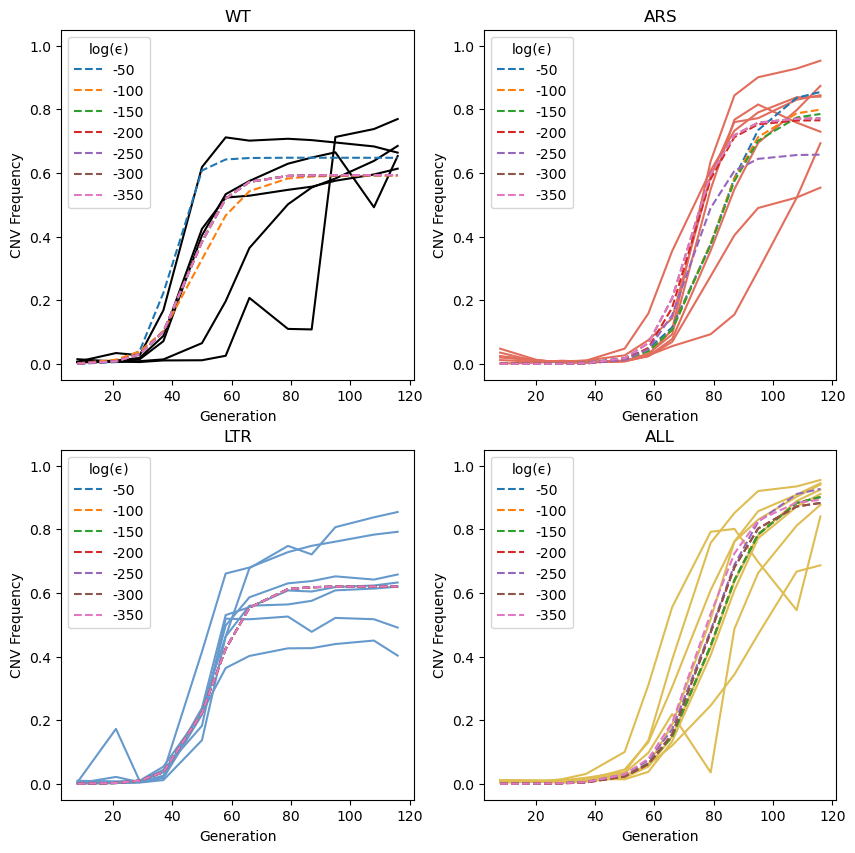

In [23]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
epsilons = [-50,-100,-150,-200,-250,-300, -350]
plot_epsilons(ax[0,0], 'wt', epsilons)
plot_epsilons(ax[1,0], 'ltr', epsilons)
plot_epsilons(ax[0,1], 'ars', epsilons)
plot_epsilons(ax[1,1], 'all', epsilons)
plt.show()

# MAPs and samples

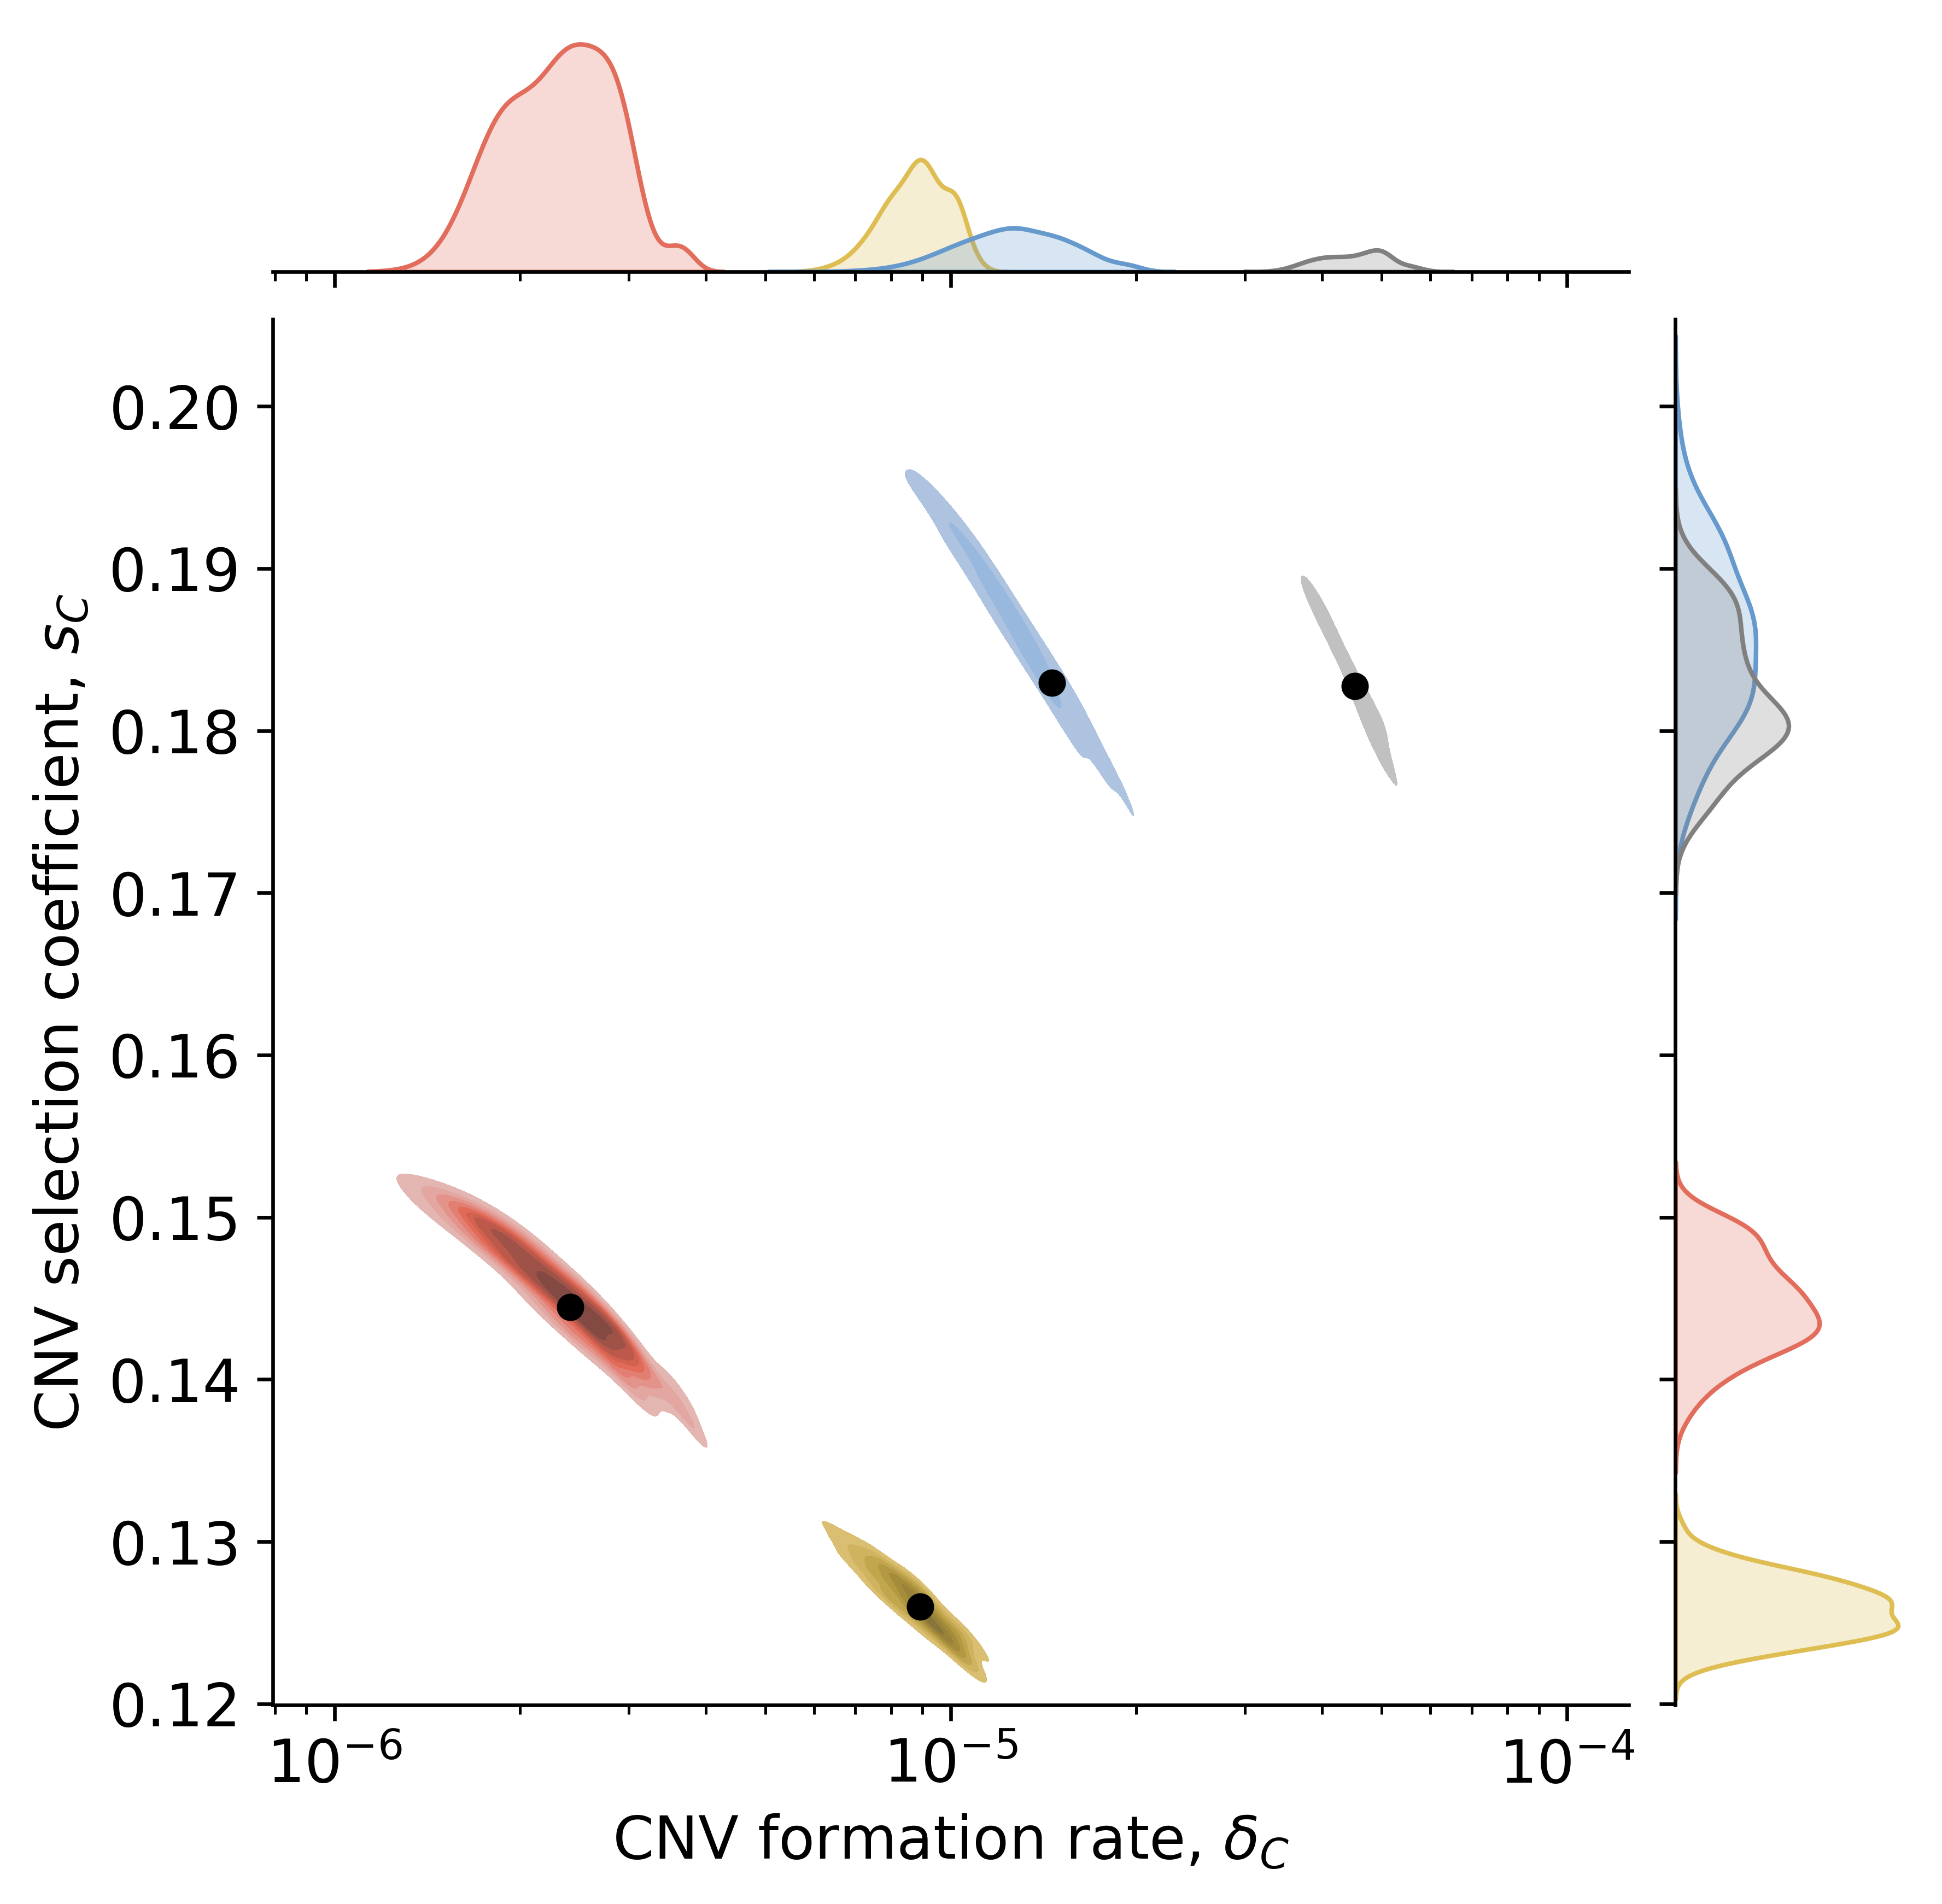

In [14]:
from seaborn import JointGrid, kdeplot, jointplot
import arviz as az
import matplotlib as mpl

# fonts
label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size
mpl.rcParams["lines.linewidth"] = 0.001

# Plot formation rate δc and fitness effect Sc for given MAPs
def plot_maps(lines):
    colors =  {'wt':"Greys", 'ltr':"Blues", 'ars': "Reds", 'all':"YlOrRd_r"}
    rep_colors = {'wt':"grey", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
    sample_df = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0)
    g = jointplot(data=sample_df, x=10**sample_df.loc[:,'$log_{10}(δ_C)$'], y=10**sample_df.loc[:,'$log_{10}(s_C)$'], hue='line', 
              palette=rep_colors, legend=False, kind='kde', fill=True, xlim=[10**-6.1, 10**-3.9])
    for line in lines: 
        op = collective_posteriors[line]
        mapp = op.map
        x, y = 10**mapp[1], 10**mapp[0]        
        g.ax_joint.scatter(x, y, color='k', s = 25) # plot MAP in black
        
    g.ax_joint.set_xlabel('CNV formation rate, $δ_C$')
    g.ax_joint.set_ylabel('CNV selection coefficient, $s_C$')
    g.ax_joint.set_xscale('log')
    return g
        
lines = ['wt', 'ltr', 'ars', 'all']
g = plot_maps(lines)

In [9]:
# Smaller prior --> faster samples

maps = pd.read_csv('maps/sbi_all_maps_chuong.csv', index_col=0)
params = maps[maps['line']=='wt'].iloc[:,2:]
params.max(),params.min()

(log(s_cnv)   -0.530188
 log(m_cnv)   -3.924773
 log(p_0)     -3.251393
 dtype: float64,
 log(s_cnv)   -0.985254
 log(m_cnv)   -5.561535
 log(p_0)     -5.471436
 dtype: float64)

In [10]:
new_prior_min = np.array(params.min())
new_prior_max = np.array(params.max())
new_prior = utils.BoxUniform(low=torch.tensor(new_prior_min), 
                         high=torch.tensor(new_prior_max))

line = 'wt'
n_eval=50
amortized_posterior = posterior_chuong
Xs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0) # observations
log_C = 1.0 # normalizing constant
op = CollectivePosterior(new_prior, amortized_posterior, Xs, n_eval, log_C, epsilon)
op.log_C = op.get_log_C()
print(op.log_C)



568.1424926203978


In [ ]:
samples = op.sample(n_samples=100)

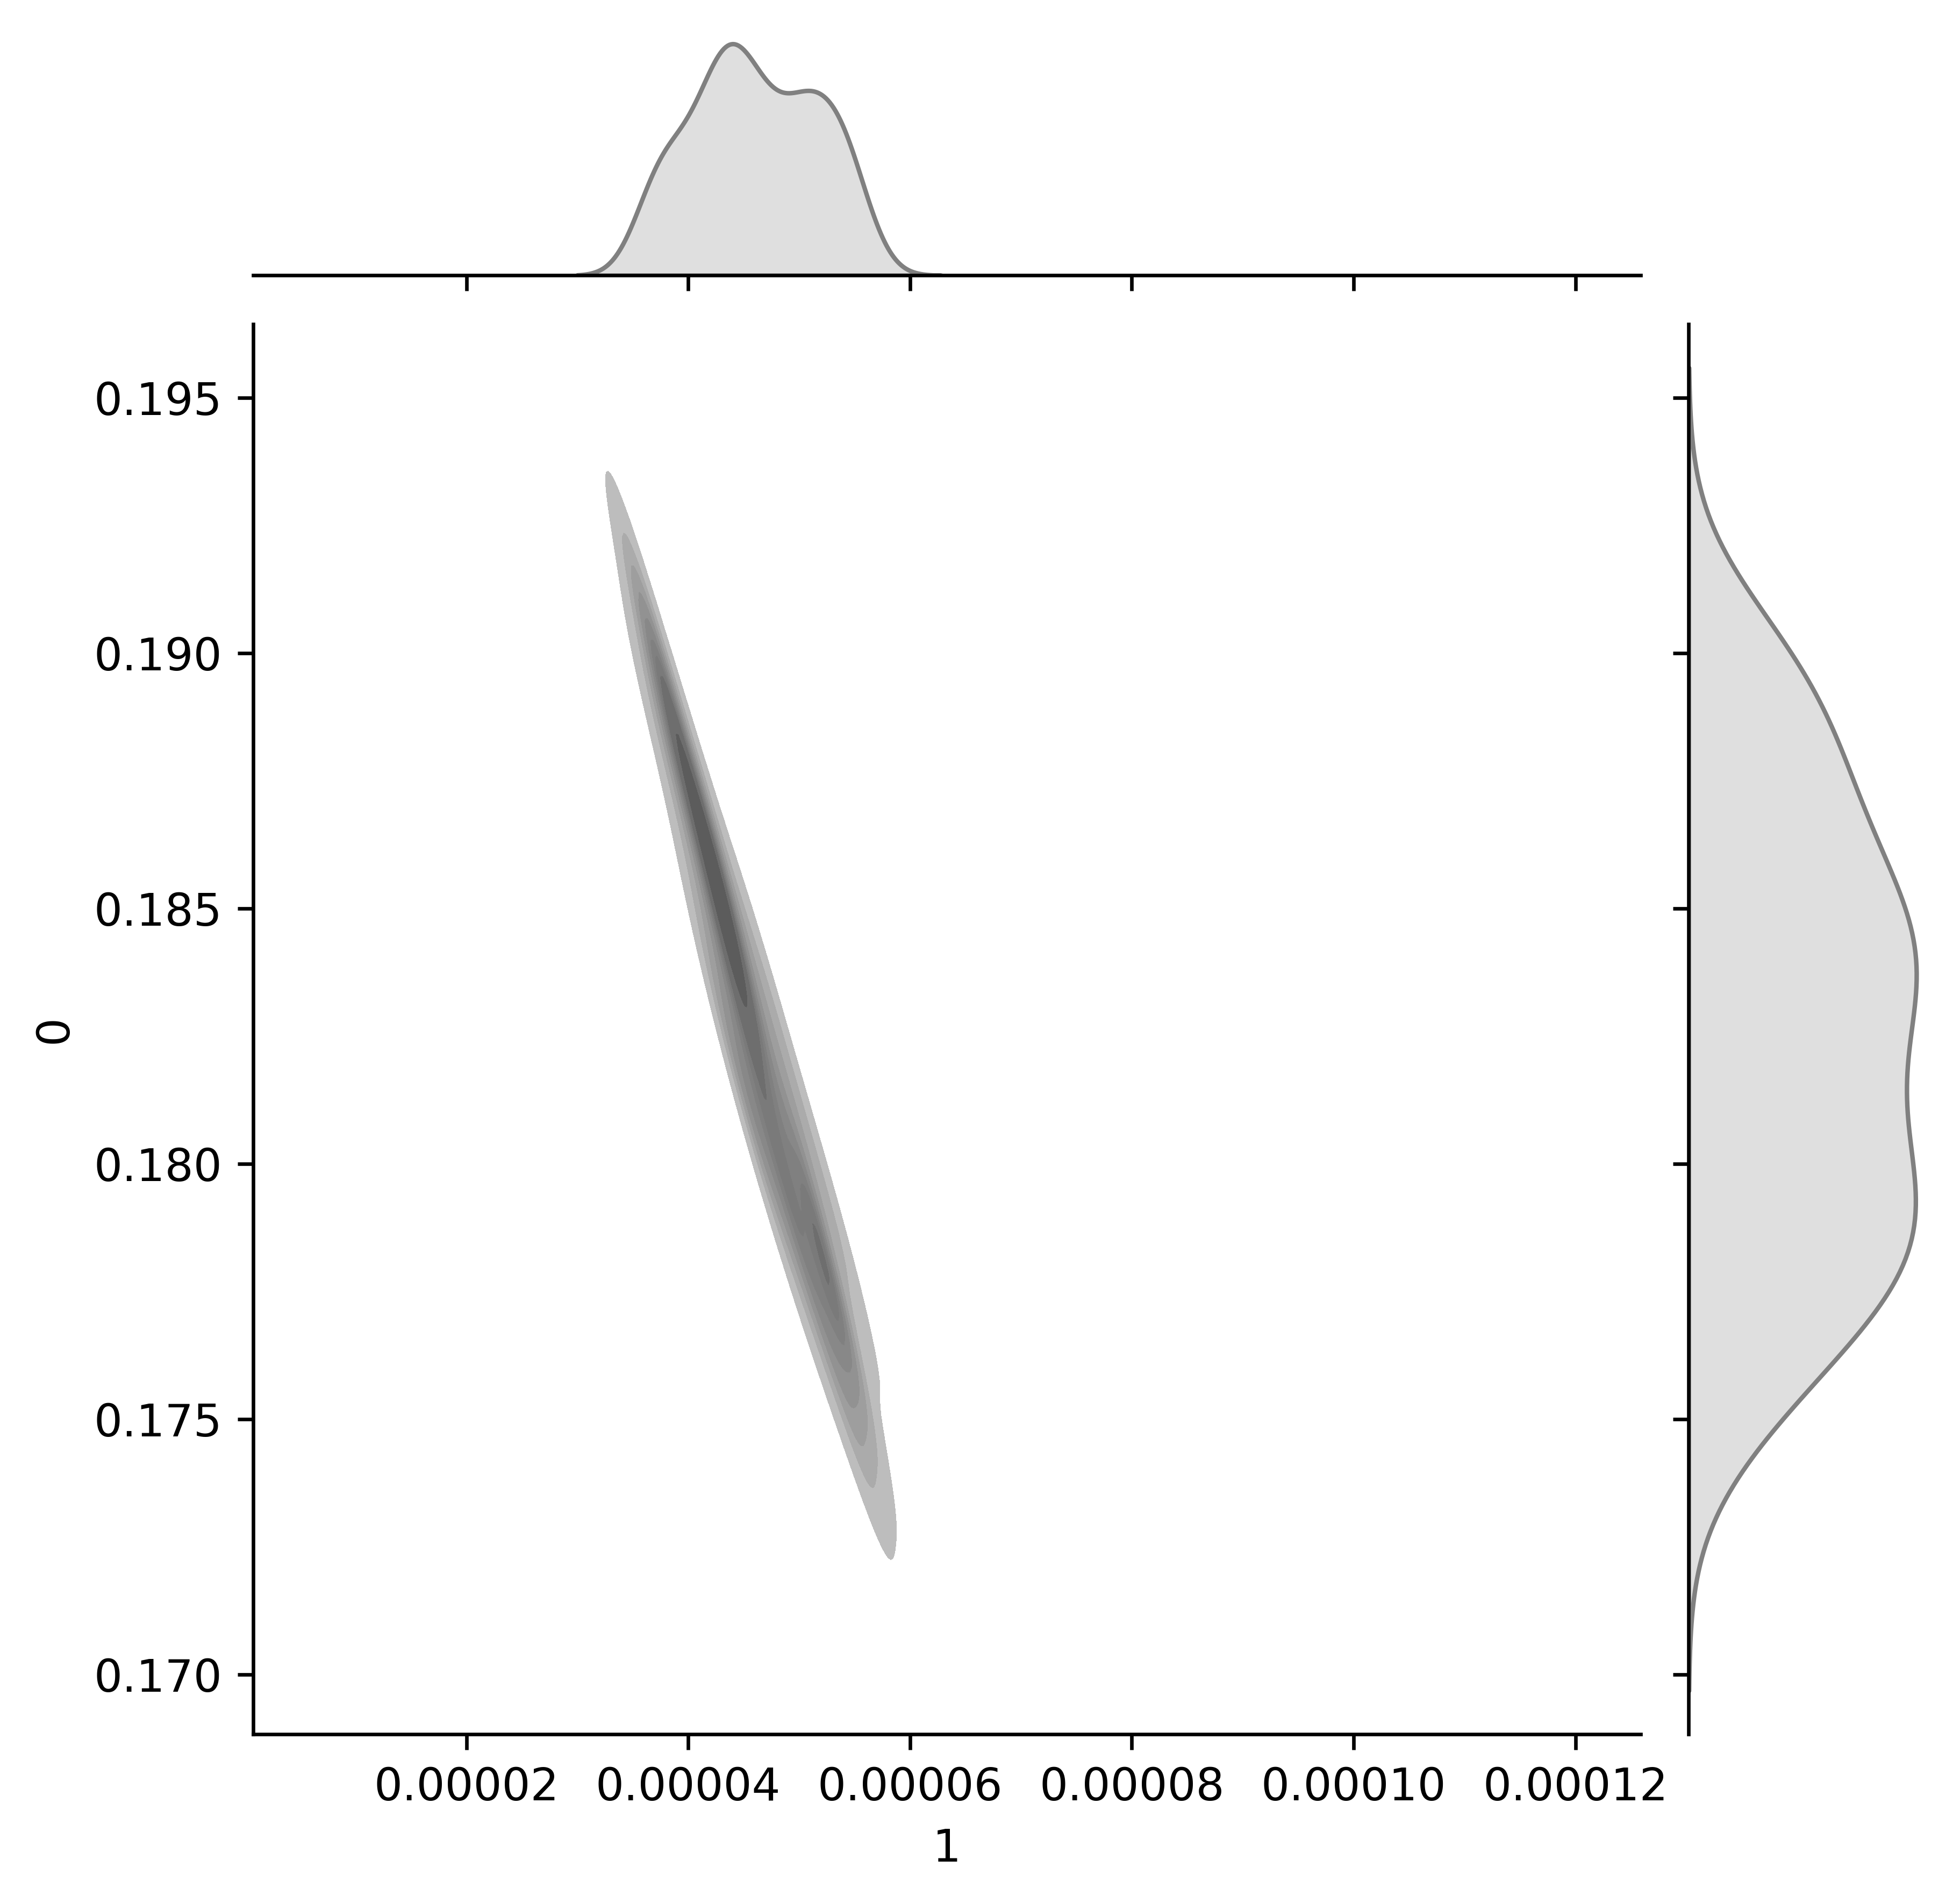

In [22]:
from seaborn import jointplot
sample_df = pd.DataFrame(samples)
g = jointplot(data=sample_df, x=10**sample_df.iloc[:,1], y=10**sample_df.iloc[:,0], 
              palette=rep_colors, legend=False, kind='kde', fill=True, xlim=[10**-6.1, 10**-3.9], color='grey')
g

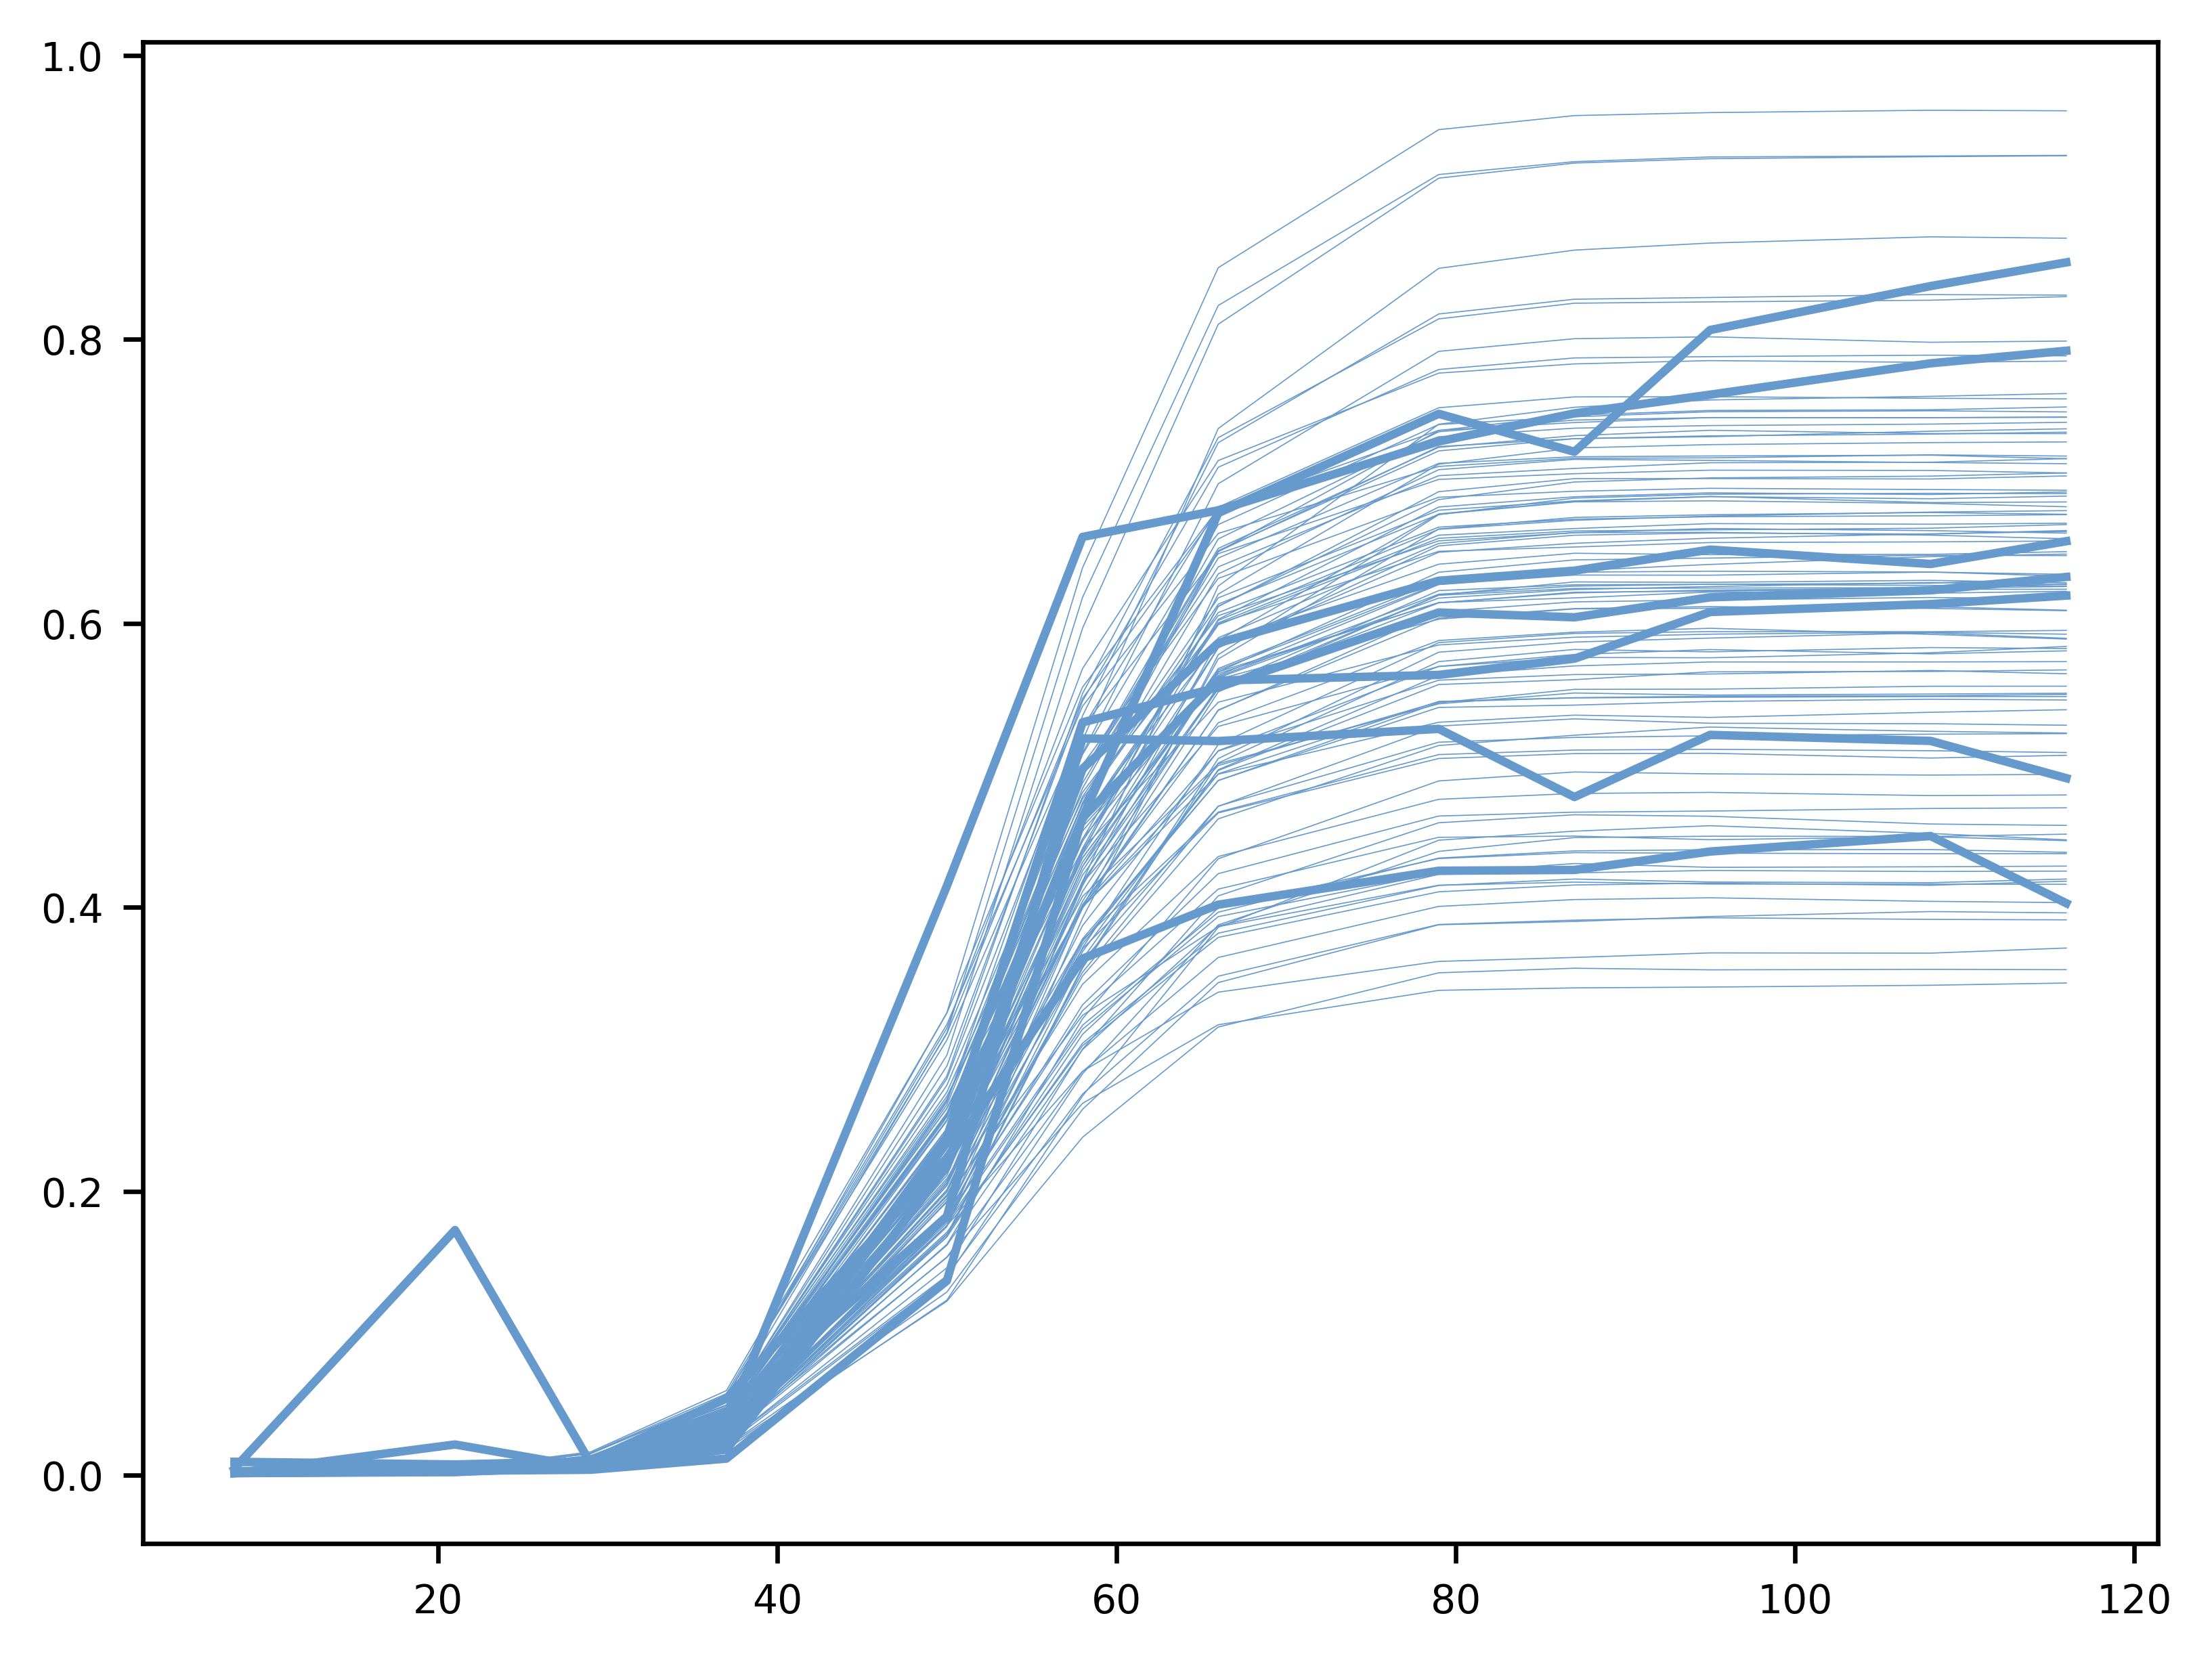

In [73]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Model (simulator)
reps = 1
generation = pd.read_csv('empirical_data/Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 7e5

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=None, parameters=cnv_params)
    return states

# Showing one example

line = 'ltr'
op = collective_posteriors[line]
for i in range(len(op.Xs)):
    plt.plot(generation.tolist(),op.Xs[i,:], color=rep_colors[line])

for i in range(100):
    y = CNVsimulator(op.samples.mean(0)).reshape(-1,1)
    plt.plot(generation, y, color=rep_colors[line], linewidth=0.2)